# Figure 4: Average 32x32 flowpic for each class across multiple data splits.

[:simple-jupyter: :material-download:](../../paper_tables_and_figures/figure4_ucdavis_per_class_average_flowpic/figure4_ucdavis_per_class_average_flowpic.ipynb)

In [1]:
import itertools

import numpy as np
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import tcbench as tcb
from tcbench import dataprep

In [4]:
FLOWPIC_DIM = 32
FLOWPIC_BLOCK_DURATION = 15

In [5]:
# load unfiltered dataset
dset = dataprep.FlowpicDataset(
    data=tcb.load_parquet(tcb.DATASETS.UCDAVISICDM19),
    timetofirst_colname="timetofirst",
    pkts_size_colname="pkts_size",
    pkts_dir_colname="pkts_dir",
    target_colname="app",
    flowpic_dim=FLOWPIC_DIM,
    flowpic_block_duration=FLOWPIC_BLOCK_DURATION,
)

In [6]:
# load the first train split
dset_train_split = dataprep.FlowpicDataset(
    data=tcb.load_parquet(tcb.DATASETS.UCDAVISICDM19, split=0),
    timetofirst_colname="timetofirst",
    pkts_size_colname="pkts_size",
    pkts_dir_colname="pkts_dir",
    target_colname="app",
    flowpic_dim=FLOWPIC_DIM,
    flowpic_block_duration=FLOWPIC_BLOCK_DURATION,
)

In [7]:
def compute_average_flowpic(df):
    # gather all (precomputed) flowpic
    # in a single tensor (n x dim x dim)
    # and do an avereage across the 1st dimension
    mtx = np.stack(df["flowpic"], axis=0).mean(
        axis=0, keepdims=True
    )  # .astype(np.uint8)
    return mtx

In [8]:
TARGETS_LABEL = sorted(dset.df["app"].unique())
PARTITIONS_NAME = sorted(dset.df["partition"].unique())
CLASSES_RENAME = {
    "google-doc": "G. Doc",
    "google-drive": "G. Drive",
    "google-search": "G. Search",
    "google-music": "G. Music",
    "youtube": "YouTube",
}

In [9]:
average_flowpic = dict()
for partition_name in [
    "pretraining",
    "train-split",
    "retraining-script-triggered",
    "retraining-human-triggered",
]:
    if partition_name != "train-split":
        df_partition = dset.df[dset.df["partition"] == partition_name]
    else:
        df_partition = dset_train_split.df

    average_flowpic[partition_name] = dict()

    for target in TARGETS_LABEL:
        df_app = df_partition[df_partition["app"] == target]
        mtx = compute_average_flowpic(df_app).squeeze()
        average_flowpic[partition_name][target] = mtx

In [10]:
mtx_min = 100
mtx_max = -100
for partition_name, app in itertools.product(
    [
        "pretraining",
        "train-split",
        "retraining-script-triggered",
        "retraining-human-triggered",
    ],
    TARGETS_LABEL,
):
    mtx = average_flowpic[partition_name][app]
    nonzero = mtx.flatten()
    nonzero = nonzero[nonzero > 0]
    if nonzero.min() < mtx_min:
        mtx_min = nonzero.min()
    if mtx.max() > mtx_max:
        mtx_max = mtx.max()

# mtx_min, mtx_max

/tmp/ipykernel_19221/3453343292.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


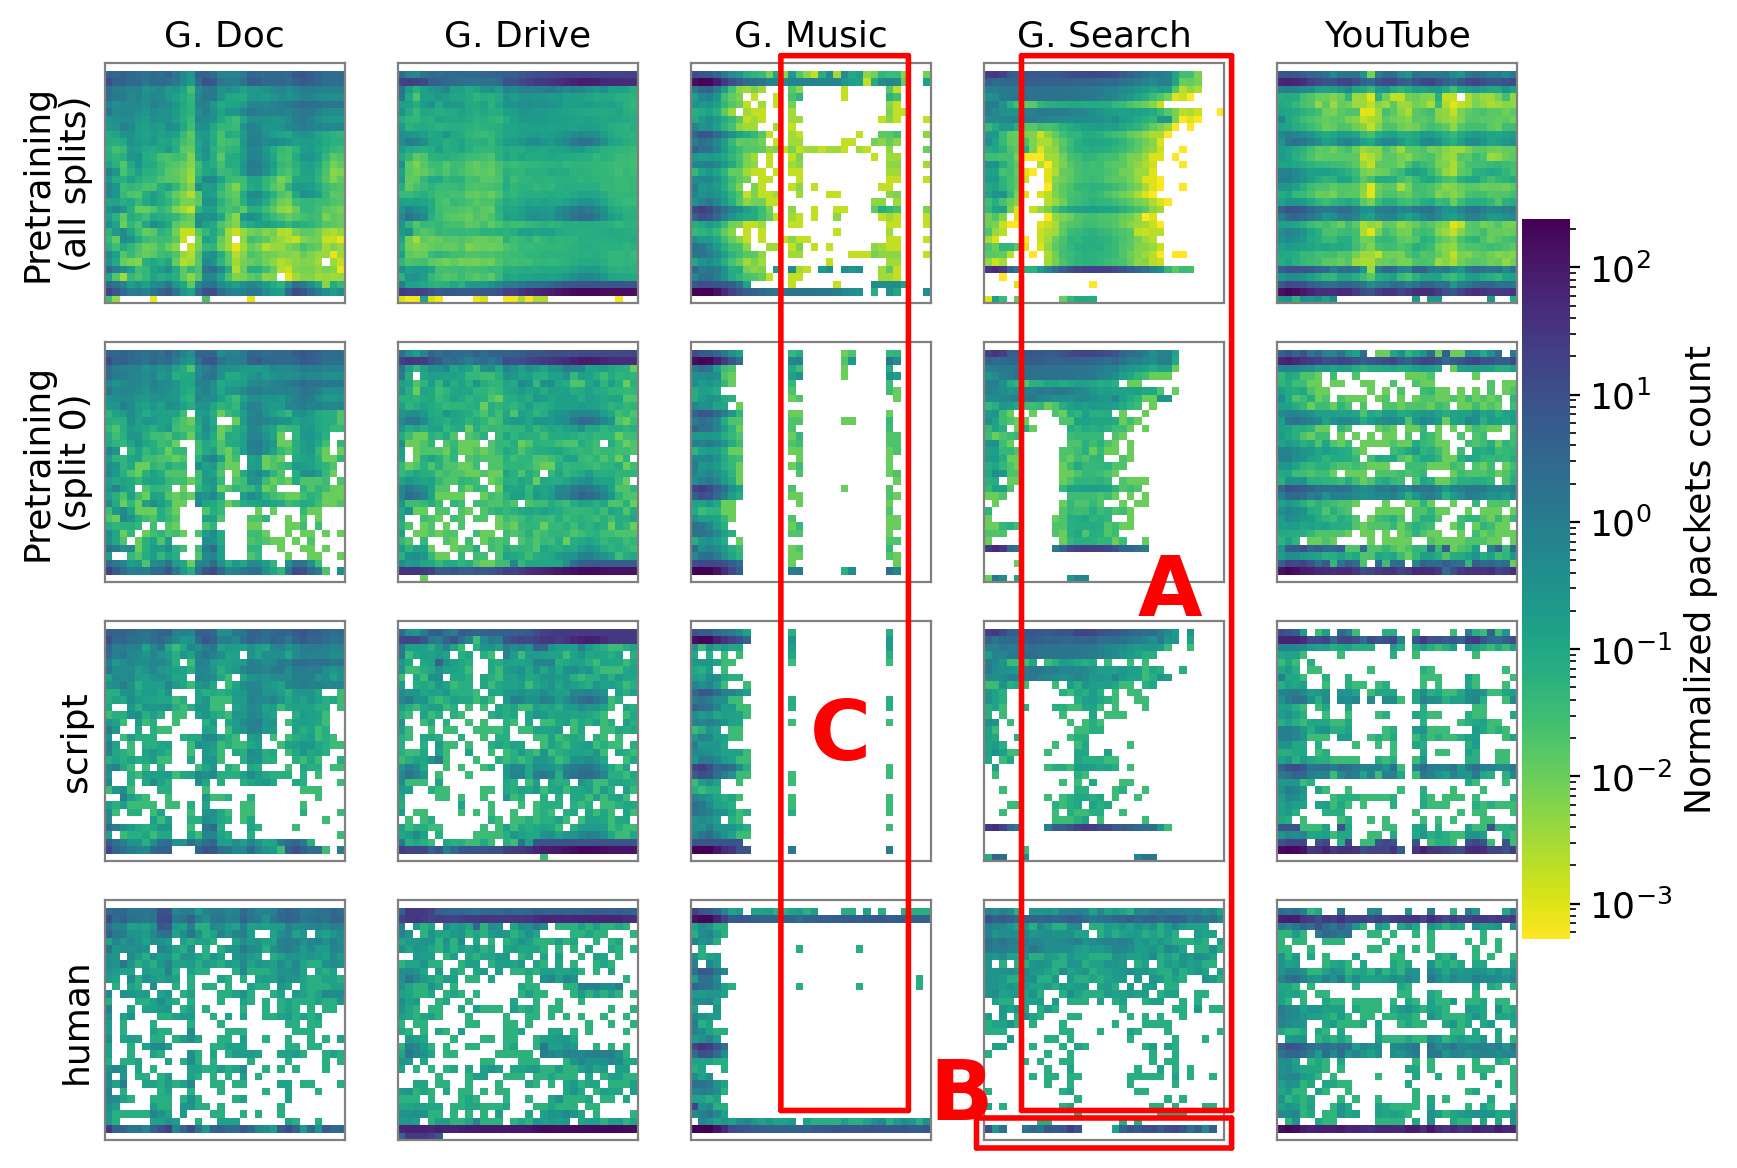

In [14]:
mpl.rcParams.update({"font.size": 13})

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8, 6), sharex=True, sharey=True)

cbar_ax = fig.add_axes([0.97, 0.2, 0.03, 0.6])  # (left, bottom, width, height)
cbar_ax.set_ylabel("packets size normalized frequency")

for i, ax, (partition_name, app) in zip(
    range(len(axes.flatten())),
    axes.flatten(),
    itertools.product(
        [
            "pretraining",
            "train-split",
            "retraining-script-triggered",
            "retraining-human-triggered",
        ],
        TARGETS_LABEL,
    ),
):
    mtx = average_flowpic[partition_name][app]

    sns.heatmap(
        ax=ax,
        data=np.where(mtx == 0, np.nan, mtx),
        vmin=mtx_min,
        vmax=mtx_max,
        cbar=i == 0,
        cmap=plt.get_cmap("viridis_r"),
        square=True,
        norm=LogNorm(mtx_min, mtx_max),
        cbar_ax=None if i else cbar_ax,  # <19
        cbar_kws=dict(label="Normalized packets count"),
    )

    # ax.set_title(target)
    for pos in ("top", "bottom", "right", "left"):
        ax.spines[pos].set_color("gray")
        ax.spines[pos].set_visible(True)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_ticks([], None)
    ax.set_ylabel("")

for ax, app in zip(axes[0], TARGETS_LABEL):
    ax.set_title(CLASSES_RENAME[app], fontsize=13)

for ax, partition_name in zip(
    axes[:, 0],
    ["Pretraining\n(all splits)", "Pretraining\n(split 0)", "script", "human"],
):
    ax.set_ylabel(partition_name, fontsize=13)

### annotations
patches = [
    ######### A #########
    # vertical
    mpl.patches.ConnectionPatch(
        xyA=(5, -1),
        coordsA=axes[0][3].transData,
        xyB=(5, 28),
        coordsB=axes[3][3].transData,
    ),
    mpl.patches.ConnectionPatch(
        xyA=(33, -1),
        coordsA=axes[0][3].transData,
        xyB=(33, 28),
        coordsB=axes[3][3].transData,
    ),
    # horizontal
    mpl.patches.ConnectionPatch(
        xyA=(5, -1),
        coordsA=axes[0][3].transData,
        xyB=(33, -1),
        coordsB=axes[0][3].transData,
    ),
    mpl.patches.ConnectionPatch(
        xyA=(5, 28),
        coordsA=axes[3][3].transData,
        xyB=(33, 28),
        coordsB=axes[3][3].transData,
    ),
    ######### B #########
    # vertical
    mpl.patches.ConnectionPatch(
        xyA=(-1, 29),
        coordsA=axes[3][3].transData,
        xyB=(-1, 33),
        coordsB=axes[3][3].transData,
    ),
    mpl.patches.ConnectionPatch(
        xyA=(33, 29),
        coordsA=axes[3][3].transData,
        xyB=(33, 33),
        coordsB=axes[3][3].transData,
    ),
    # horizontal
    mpl.patches.ConnectionPatch(
        xyA=(-1, 29),
        coordsA=axes[3][3].transData,
        xyB=(33, 29),
        coordsB=axes[3][3].transData,
    ),
    mpl.patches.ConnectionPatch(
        xyA=(-1, 33),
        coordsA=axes[3][3].transData,
        xyB=(33, 33),
        coordsB=axes[3][3].transData,
    ),
    ######### C #########
    # vertical
    mpl.patches.ConnectionPatch(
        xyA=(12, -1),
        coordsA=axes[0][2].transData,
        xyB=(12, 28),
        coordsB=axes[3][2].transData,
    ),
    mpl.patches.ConnectionPatch(
        xyA=(29, -1),
        coordsA=axes[0][2].transData,
        xyB=(29, 28),
        coordsB=axes[3][2].transData,
    ),
    # horizontal
    mpl.patches.ConnectionPatch(
        xyA=(12, -1),
        coordsA=axes[0][2].transData,
        xyB=(29, -1),
        coordsB=axes[0][2].transData,
    ),
    mpl.patches.ConnectionPatch(
        xyA=(12, 28),
        coordsA=axes[3][2].transData,
        xyB=(29, 28),
        coordsB=axes[3][2].transData,
    ),
]

for p in patches:
    p.set(color="red", linewidth=2)
    fig.add_artist(p)

fig.text(0.73, 0.47, "A", color="red", fontweight="bold", fontsize=30)
fig.text(0.6, 0.05, "B", color="red", fontweight="bold", fontsize=30)
fig.text(0.525, 0.35, "C", color="red", fontweight="bold", fontsize=30)

plt.savefig(
    "ucdavis_dataset_different_partition.png",
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=300,
)
plt.tight_layout()